## Step 1: Project Initialization Setting up the environment and defining directory paths for the dataset. This ensures the workflow is organized and reproducible across different local environments.

In [ ]:
import pandas as pd
folder_path = r'C:\Users\Vedika Desai\Downloads\data'

train_trans_path = folder_path + r'\train_transaction.csv'
train_id_path = folder_path + r'\train_identity.csv'

print("Path setup successfully!")

## Step 2: Data Ingestion Loading the IEEE-CIS Transaction and Identity datasets. To optimize memory usage during the initial exploration, we load a subset of the transaction records while maintaining the full identity context

In [2]:
# Load the transaction file
train_transaction = pd.read_csv(train_trans_path, nrows=100000)

# Load the identity file
train_identity = pd.read_csv(train_id_path)

print("Files loaded into Python!")

Files loaded into Python!


## Step 3: Feature Integration Combining the Transaction and Identity tables using a left join on TransactionID. This allows the model to analyze both payment details and device/network metadata simultaneously

In [3]:
# Merge them together
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')

# Show the first 5 rows to confirm it worked
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


## Step 4: Target Distribution Analysis Examining the ratio of fraudulent to legitimate transactions. The significant class imbalance (~2.5% fraud) indicates that standard accuracy will not be a reliable metric; we must prioritize precision and recall.

In [4]:
# See how many transactions are Fraud (1) vs Normal (0)
print(train['isFraud'].value_counts())

# See it as a percentage
print(train['isFraud'].value_counts(normalize=True) * 100)


isFraud
0    97439
1     2561
Name: count, dtype: int64
isFraud
0    97.439
1     2.561
Name: proportion, dtype: float64


## Step 5: Missing Value Assessment Calculating the percentage of null values per feature. Many columns in this dataset have high sparsity (over 90% missing), which requires a strategic approach to data imputation

In [5]:
# Calculate the percentage of missing values for each column
null_counts = train.isnull().sum() / len(train) * 100
print(null_counts.sort_values(ascending=False).head(20))

id_24    98.500
id_25    98.388
id_21    98.380
id_07    98.377
id_26    98.377
id_08    98.377
id_22    98.376
id_23    98.376
id_27    98.376
D7       93.928
dist2    91.769
D13      90.479
D12      89.495
D14      88.847
D6       87.259
id_18    87.019
M7       83.961
M9       83.961
M8       83.961
id_03    81.433
dtype: float64


## Step 6: Comparative Analysis of Transaction Amounts Visualizing the distribution of transaction amounts across classes. This helps identify if fraudulent activity is correlated with specific spending thresholds or outlier values

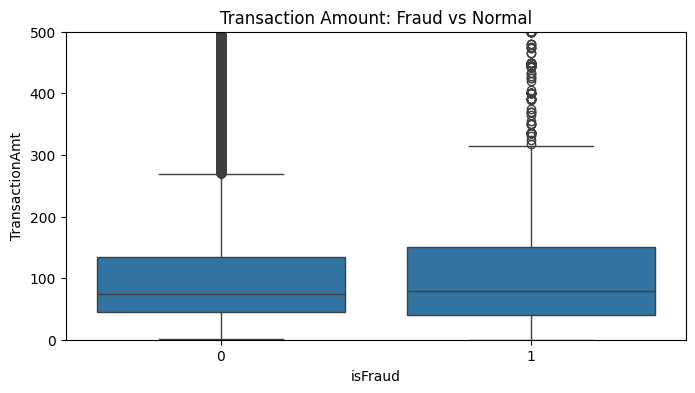

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a boxplot to compare amounts
plt.figure(figsize=(8, 4))
sns.boxplot(x='isFraud', y='TransactionAmt', data=train)
plt.ylim(0, 500) # Limit to $500 so we can see the boxes clearly
plt.title('Transaction Amount: Fraud vs Normal')
plt.show()

## Step 7: Data Imputation Strategy Handling missing data by filling numerical gaps with a sentinel value (-999) and categorical gaps with an 'unknown' label. This preserves the dataset size while allowing the algorithm to interpret missingness as a potential signal.

In [7]:
numerical_cols = train.select_dtypes(include=['number']).columns
train[numerical_cols] = train[numerical_cols].fillna(-999)

object_cols = train.select_dtypes(include=['object']).columns
train[object_cols] = train[object_cols].fillna('unknown')

print("Missing values have been filled!")

Missing values have been filled!


## Step 8: Categorical Feature Encoding Utilizing LabelEncoder to transform non-numeric categorical data into a machine-readable format. This is a critical step for preparing features like 'ProductCD' and 'Card4' for the Random Forest algorithm

In [8]:
from sklearn.preprocessing import LabelEncoder

# Identify the columns that contain text (objects)
cat_cols = train.select_dtypes(include=['object']).columns

# Initialize the LabelEncoder
le = LabelEncoder()

# Loop through each text column and turn words into numbers
for col in cat_cols:
    train[col] = le.fit_transform(train[col].astype(str))

print("All text columns have been converted to numbers!")
train[cat_cols].head()

All text columns have been converted to numbers!


,ProductCD,card4,card6,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,...,id_30,id_31,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,4,1,1,48,49,0,1,1,2,0,...,67,81,132,4,2,2,2,2,2,864
1,4,2,1,16,49,1,2,2,0,1,...,67,81,132,4,2,2,2,2,2,864
2,4,4,2,35,49,0,1,1,0,0,...,67,81,132,4,2,2,2,2,2,864
3,4,2,2,54,49,1,2,2,0,1,...,67,81,132,4,2,2,2,2,2,864
4,1,2,1,16,49,1,2,2,3,2,...,7,79,81,3,1,0,1,1,1,423


## Step 9: Stratified Data Splitting Partitioning the data into training (80%) and testing (20%) sets. We apply stratification to ensure that the rare fraud class is proportionally represented in both subsets, preventing biased evaluation.

In [9]:
from sklearn.model_selection import train_test_split

# X = Everything EXCEPT the answer (the clues)
# y = The answer (is it fraud or not?)
X = train.drop(['isFraud', 'TransactionID'], axis=1)
y = train['isFraud']

# Split: 80% for learning, 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")

Training set size: (80000, 432)
Testing set size: (20000, 432)


## Step 10: Random Forest Classifier Implementation Training a Random Forest model with 100 estimators. We constrain the max_depth to 10 to ensure the model generalizes well to new data and avoids overfitting to specific training noise

In [10]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, max_depth=10, n_jobs=-1, random_state=42)

# Start the training (this might take 1-2 minutes)
model.fit(X_train, y_train)

print("The model has finished training!")

The model has finished training!


## Step 11: Comprehensive Performance Metrics Evaluating the model using ROC-AUC and Precision-Recall AUC. Given the class imbalance, PR-AUC provides a more accurate reflection of the model's ability to identify fraud without excessive false positives.

In [11]:
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc

y_probs = model.predict_proba(X_test)[:, 1]

# 1. Calculate ROC-AUC (How well the model distinguishes classes)
roc_auc = roc_auc_score(y_test, y_probs)
print(f"Professional Metric - ROC-AUC: {roc_auc:.4f}")

# 2. Calculate Precision-Recall AUC (The gold standard for imbalanced data)
precision, recall, _ = precision_recall_curve(y_test, y_probs)
pr_auc = auc(recall, precision)
print(f"Professional Metric - PR-AUC: {pr_auc:.4f}")

# 3. Detailed Report
print("\nDetailed Classification Report:")
print(classification_report(y_test, model.predict(X_test)))

Professional Metric - ROC-AUC: 0.8516
Professional Metric - PR-AUC: 0.4749

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     19488
           1       0.94      0.23      0.37       512

    accuracy                           0.98     20000
   macro avg       0.96      0.62      0.68     20000
weighted avg       0.98      0.98      0.97     20000



## Step 12: Model Serialization for Deployment Exporting the trained model and feature list using joblib. These artifacts are essential for the Streamlit dashboard, enabling real-time inference in a production-like environment.

In [12]:
import joblib

# The path where your other files are
save_path = r'C:\Users\Vedika Desai\Downloads\data/'

# 1. Save the model (The Brain)
joblib.dump(model, save_path + 'fraud_model_v1.pkl')

# 2. Save the column names (The Clues)
# This ensures the dashboard uses the exact same order as the training
joblib.dump(X.columns.tolist(), save_path + 'model_features.pkl')

print("✅ Success! Files 'fraud_model_v1.pkl' and 'model_features.pkl' created in your data folder.")

✅ Success! Files 'fraud_model_v1.pkl' and 'model_features.pkl' created in your data folder.


## Step 13: Risk Analysis and Dashboard Validation Identifying specific high-risk 'Card IDs' from the training set. This data serves as a validation tool to test the sensitivity and accuracy of the live fraud detection dashboard

In [13]:
# Find the Card IDs that have the actual highest fraud rates
fraud_analysis = train.groupby('card1')['isFraud'].mean().sort_values(ascending=False)
# Filter for cards that appear at least 10 times to avoid random noise
common_fraud_cards = train['card1'].value_counts()[train['card1'].value_counts() > 10].index
top_fraud_id = fraud_analysis[fraud_analysis.index.isin(common_fraud_cards)].head(5)

print("Enter one of these Card IDs into your app to trigger the model:")
print(top_fraud_id)

Enter one of these Card IDs into your app to trigger the model:
card1
9375     0.913043
5853     0.909091
9635     0.705882
16095    0.636364
2939     0.552632
Name: isFraud, dtype: float64


In [14]:
# Find Card IDs that have a 100% fraud rate in the data
high_risk_cards = train.groupby('card1')['isFraud'].mean()
trigger_ids = high_risk_cards[high_risk_cards > 0.8].index[:5]

print("Type one of these Card IDs into your app to see the RED alert:")
print(list(trigger_ids))

Type one of these Card IDs into your app to see the RED alert:
[1394, 1775, 2034, 2553, 2743]
